# Работа с API YandexART

In [1]:
import requests
import json
import time
from datetime import datetime
from IPython import display
from base64 import b64decode

Для работы с API YandexART необходим идентификатор каталога и API-ключ для сервисного аккаунта Яндекс.Облака с ролью 'ai.imageGeneration.user'.

Подробнее о создании API-ключа: https://yandex.cloud/ru/docs/iam/concepts/authorization/api-key

In [2]:
yandex_cloud_catalog = ""
yandex_api_key = ""

Параметры генерации
- temperature: чем выше значение этого параметра, тем более креативными и случайными будут ответы модели. Принимает значения от 0 до 1. Значение по умолчанию: 0.3
- seed: инициализатор случайных чисел. Одинаковые значения будут приводить к генерации одинаковых картинок для одних и тех же запросов. Принимает значение от 0 до 2^64 - 1
- prompt: запрос для генерации картинки

In [3]:
temperature = 0.5
seed = int(round(datetime.now().timestamp()))
prompt = "Милый пушистый котенок в скафандре, на планете, сделанной из шерсти, высокая детализация, свечение, высокое разрешение, бионическое животное, крупный план, глубина, гиперреализм, Octane render,f/2.8, ISO 200"

Выполнение запроса на генерацию картинки в асинхронном режиме. Генерация может выполняться до 1 минуты. В результате выполнения запроса получаем operation_id, с помощью которого можно получать результат, выполнив отдельный запрос

In [4]:
body = {
    "modelUri": f"art://{yandex_cloud_catalog}/yandex-art/latest",
    "generationOptions": {"seed": seed, "temperature": temperature},
    "messages": [
        {"weight": 1, "text": prompt},
    ],
}

url = "https://llm.api.cloud.yandex.net/foundationModels/v1/imageGenerationAsync"
headers = {"Authorization": f"Api-Key {yandex_api_key}"}

response = requests.post(url, headers=headers, json=body)
response_json = json.loads(response.text)
print(response_json)
operation_id = response_json["id"]

{'id': 'fbvc6s6kejeedr4hg5pv', 'description': '', 'createdAt': None, 'createdBy': '', 'modifiedAt': None, 'done': False, 'metadata': None}


Необходимо дождаться генерации изображения. Для этого в цикле будем проверять готовность результата. Когда изображение будет сгенерировано,результат придет в кодировке Base64

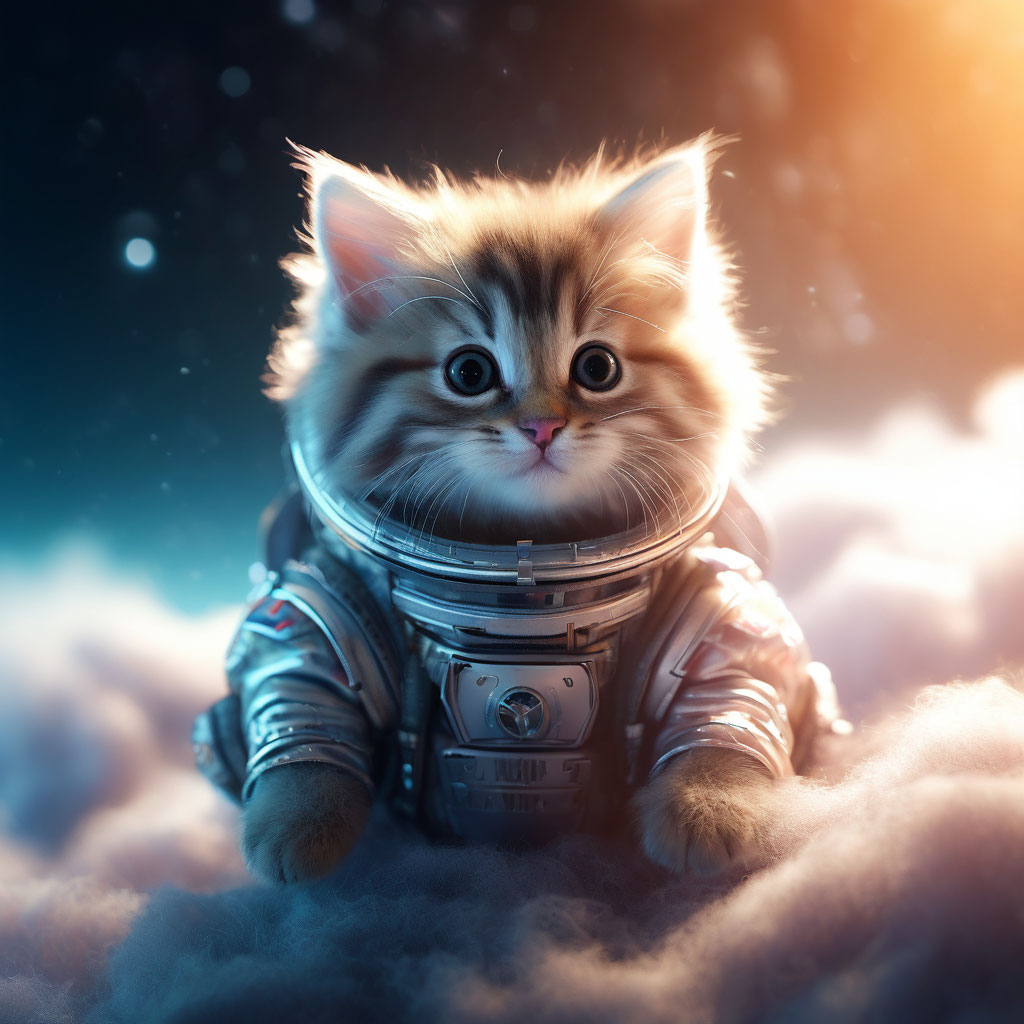

In [5]:
url = f"https://llm.api.cloud.yandex.net:443/operations/{operation_id}"
headers = {"Authorization": f"Api-Key {yandex_api_key}"}

while True:
    response = requests.get(url, headers=headers)
    response_json = json.loads(response.text)
    done = response_json["done"]
    if done:
        break
    else:
        time.sleep(2)

image_data = response_json["response"]["image"]
display.Image(b64decode(image_data))